# Explainable AI

*Still under construction*

A big problem of artificial neural networks is that they are commonly considered as "black boxes". This means that we generally only know about the input and the output but what happens in between is unknown. While the classification accuracies may be high we do not know how they got to their decisions. It is possible that a neural network perfected to distinguish certain patterns in the data which have nothing to do with the actual thing. 

This is where explainable AI comes into play. The idea behind is to create a map of scores or measures that indicate the importance of a given feature/pixel/voxel in the input space. 

Here is an illustration of the [layer-wise relevance propagation](https://www.hhi.fraunhofer.de/en/departments/ai/technologies-and-solutions/layer-wise-relevance-propagation.html) (LRP) algorithm developed in the lab of Wojciech Samek and Sebastian Lapuschkin:

![LRP illustration](https://www.hhi.fraunhofer.de/fileadmin/_processed_/b/9/csm_lrp-algorithm_044c31eb4a.png)

The LRP algorithm is already implemented in many python toolboxes. In case you want to check them out for yourself here is a collection  of Explainable AI toolboxes: 
* [iNNvestigate](https://github.com/albermax/innvestigate)
* [Zennit](https://github.com/chr5tphr/zennit)
* [Captum](https://github.com/pytorch/captum)
* SHAP, see [A](https://proceedings.neurips.cc/paper/2017/file/8a20a8621978632d76c43dfd28b67767-Paper.pdf) and [B](https://github.com/slundberg/shap)

Here we will take a look at the [Zennit](https://github.com/chr5tphr/zennit) toolbox.

In [38]:
import os
import sys
module_path = os.path.abspath(os.path.join('../../fmriDEEP'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [39]:
import torch
import numpy as np
from _core.networks.ConvNets import Simple2dCnnClassifier
from _core.utils.tools import compute_accuracy
from torch.utils.data import DataLoader, Subset
from zennit import composites
from torchvision.datasets import MNIST, FashionMNIST
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt

# this variable contains information whether a GPU can be used for training. If not, we automatically use the CPU.
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

<p align="justify">To ensure reproducibility we set the random seed for all sorts of randomizer tools.</p>

In [40]:
# set the random seed for reproducibility
def set_random_seed(seed):
    import random 
    
    torch.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)
    g = torch.Generator() # can be used in pytorch dataloaders for reproducible sample selection when shuffle=True
    g.manual_seed(seed)
    
    return g

g = set_random_seed(42)

In [57]:
# function to run the train function independent of the 
# supplied network class
# when done training, save the model at "save_name"
def train_net(model, n_epochs, lr=.01, device=torch.device("cpu"), save_name=None):
    # set some variables here, such that we can create pretty plots
    # we could make these return parameters
    train_loss = np.zeros(n_epochs)
    test_loss = np.zeros_like(train_loss)
    train_acc = np.zeros_like(train_loss)
    test_acc = np.zeros_like(train_loss)

    # loop for the above set number of epochs
    for epoch in range(0, n_epochs):

        # THIS IS WHERE THE MAGIC HAPPENS
        # calling the model.fit() function will execute the 'standard_train' function as defined above.
        train_loss[epoch], train_stats = model.fit(dl_train, lr=lr, device=device)
        train_acc[epoch] = compute_accuracy(train_stats[:, -1], train_stats[:, -2])

        # for validating or testing set the network into evaluation mode such that layers like dropout are not active
        with torch.no_grad():
            test_loss[epoch], test_stats = model.fit(dl_test, device=device, train=False)
            test_acc[epoch] = compute_accuracy(test_stats[:, -1], test_stats[:, -2])

        print('epoch=%03d, train_loss=%1.3f, train_acc=%1.3f, test_loss=%1.3f, test_acc=%1.3f' % 
             (epoch, train_loss[epoch], train_acc[epoch], test_loss[epoch], test_acc[epoch]))

    model.save(save_name, save_full=True)

For this chapter we will use the ```Fashion MNIST``` dataset.

In [60]:
training_data = FashionMNIST(root="data",train=True,download=True,transform=ToTensor())
dl_train = DataLoader(training_data, batch_size=256, shuffle=True)

test_data = FashionMNIST(root="data",train=False,download=True,transform=ToTensor())
dl_test = DataLoader(test_data, batch_size=256, shuffle=False)

Let's look at an example image of the dataset. 

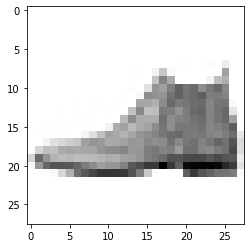

In [43]:
# show an example of the Fashion MNIST dataset
plt.imshow(test_data.data[0, :, :], cmap='Greys');

## Feature relevance in 2d Fashion MNIST

As we have learned in previous chapters it is quite easy to create a new ```Simple2dCnnClassifier```. After we created the network we train it for some epochs. 

I have already done the training, so I am simply loading the save state.

In [44]:
model = Simple2dCnnClassifier((28, 28), 10)

In [69]:
%%script echo Skipping the training procedure
train_net(model, 10, save_name='my_cnn_fashionmnist')

Skipping the training procedure


In [70]:
# loading the already trained model
model = torch.load('my_cnn_fashionmnist/model.pth')

Unfortunately, I did not yet get around to make functions for the "explaining" code from [Zennit](https://github.com/chr5tphr/zennit). 

It will get easier but for now let us go through the code step by step:

In [68]:
shape = (1, 1, 28, 28)

# Zennit provides multiple options rules for computation.
# In a paper, Montavon, et. al (https://iphome.hhi.de/samek/pdf/MonXAI19.pdf) 
# showed that a composite of different rules e.g., the epsilon gamma rules works best 
# for neural networks that are a combination of convolutional and linear layers.
composite_kwargs = {
    'low': 0 * torch.ones(*shape, device=torch.device("cpu")),  # the lowest and ...
    'high': 1 * torch.ones(*shape, device=torch.device("cpu")),  # the highest pixel value for ZBox
}
# In this line I am telling zennit what kind of rule I want to use and supply
# some arguments. 
attributor = composites.COMPOSITES['epsilon_gamma_box'](**composite_kwargs)

# We can turn off the gradients for each layer, we wont need them.
# This makes the foward pass faster etc.
for param in model.parameters():
    param.requires_grad = False

# simply the image from a batch to pick for plotting
pick_img = 1
    
fig, axes = plt.subplots(1, 10, figsize=(20, 8), sharex=True, sharey=True)

# Now we activate the attributer context in which we can use Zennit functionality.
# this allows us accumulate the relevance scores in the input space by calling
# the torch.autograd.backward function.
# Zennit sort of "overrides" the rules what to compute in the backward pass.
# This results in relevance maps in the input space.
with attributor.context(model) as modified_model:
    ctr = 0
    for i, (data, target) in enumerate(dl_test):
        # we do not want the actuall input to change
        data_with_grad = data.clone()
        
        # the copied input needs gradients so we can change them
        # during the backward pass
        data_with_grad.requires_grad_()

        # the label in one-hot encoding
        output_relevance = torch.eye(10, device=torch.device("cpu"))[target]

        # forward pass with the zennit-modified model
        out = modified_model(data_with_grad)
        
        # what did the model predict
        predicted = np.argmax(out.detach().numpy(), axis=1)
        
        # magic :)
        torch.autograd.backward(out, output_relevance)
        
        # plot some images (relevance overlayed on the original)
        axes[ctr].imshow(data[pick_img, :, :].squeeze().squeeze().cpu().numpy(), cmap='Greys')
        axes[ctr].imshow(data_with_grad.grad[pick_img,:,:].squeeze().squeeze().cpu().numpy(), cmap='coolwarm', alpha=.5)
        axes[ctr].set_title(f'{predicted[pick_img]}-{target[pick_img]}')

        ctr += 1
        if ctr > 9:
            break

skipping


## Explain brain data

So far we have not talked about brain data. That is quite unfortunate but it is always good to start with the easier tasks :).

Let's say we want to train a neural network that can identify brain states, or important brain areas involved in a task, based on 3-dimensional functional magnetic resonance imaging (fMRI) data. For example, we want to know...
* ... if we can classify between brain patterns of hand, foot, and tongue movement
* ... see which brain areas the neural network deems most relevant for its decision

With the knowledge and the tools we now have at our disposal we can do the following:

1. Write or use a Dataset that can handle Nifti data (e.g., use the ```_core.datasets.NiftiDataset```)
2. Create a neural network that can handle 3-dimensional fMRI data (e.g., the ```BrainStateClassifier3d```
3. Train the network using the ```BrainStateClassifier3d.fit()```method
4. Check the classification performance of the network
5. Use the layer-wise relevance propagation (LRP) algorithm to identify important voxels
6. Look at the LRP maps :)

I have already done steps 1-4 so these steps are pretty much skipped. But it is no different than training on the MNIST datasets, so you should be quite familiar with the process by now.

In [72]:
from nltools.data import Brain_Data
from _core.utils.train_fns import standard_train
from _core.networks.ConvNets import BrainStateClassifier3d
from _core.utils.datasets import NiftiDataset
import _core.utils.tools as utils
import glob

In [51]:
# 1. create the datasets and dataloaders
labels = ['handleft', 'handright', 'footleft', 'footright', 'tongue']
dl_train = DataLoader(NiftiDataset(
    'data/brain_data/train', labels, 150, DEVICE, transform=utils.ToTensor()), 
    batch_size=4, shuffle=True, generator=g
)
dl_test = DataLoader(NiftiDataset(
    'data/brain_data/test', labels, 20, DEVICE, transform=utils.ToTensor()), 
    batch_size=4, shuffle=True, generator=g
)

In [52]:
%%script echo Already ran. Skipping to save time.
# 2. create the 3d BrainStateClassifier
model = BrainStateClassifier3d((91, 109, 91), len(labels)).to(DEVICE)

# 3. train the network
train_net(model, 100, lr=.00001, device=DEVICE, save_name='motor-mapper')

Already ran. Skipping to save time.


In [74]:
%%script echo Already ran. Skipping to save time.
# 5. Execute the LRP algorithm and save the resulting 
# LRP maps somewhere.
shape = (1, 1, 91, 109, 91)

composite_kwargs = {
    'low': -1 * torch.ones(*shape, device=torch.device("cpu")),  # the lowest and ...
    'high': 1 * torch.ones(*shape, device=torch.device("cpu")),  # the highest pixel value for ZBox
}

attributor = composites.COMPOSITES['epsilon_gamma_box'](**composite_kwargs)

for param in model.parameters():
    param.requires_grad = False

# create the composite context outside the main loop, such that the canonizers and hooks do not
# need to be registered and removed for each step.
with attributor.context(model) as modified_model:
    for j in range(len(labels)):
        dl = DataLoader(
            NiftiDataset('data/brain_data/test', [labels[j]], 20, torch.device("cpu"), 3),
            batch_size=20, shuffle=False, num_workers=0
        )

        for i, (volume, target) in enumerate(dl):
            data_norm = (volume.float().to(DEVICE))
            data_norm.requires_grad_()

            # one-hot encoding of the target labels
            output_relevance = torch.eye(model.config['n_classes'], device=torch.device("cpu"))[target]
            out = modified_model(data_norm)
            # a simple backward pass will accumulate the relevance in data_norm.grad
            torch.autograd.backward((out,), (output_relevance,))
            indi_lrp = np.moveaxis(data_norm.grad.squeeze().detach().numpy(), 0, -1)
            avg_lrp = indi_lrp.mean(axis=-1)

        utils.save_in_mni(indi_lrp, os.path.join('motor-mapper', 'lrp_%s.nii.gz' % labels[j]))
        utils.save_in_mni(avg_lrp, os.path.join('motor-mapper', 'lrp_avg_%s.nii.gz' % labels[j]))


Already ran. Skipping to save time.


You can now look at the average LRP maps for the classes (volume slider) or...

In [54]:
files = sorted(glob.glob('motor-mapper/lrp_avg*.nii.gz'))
dat = Brain_Data(files)
dat.iplot(threshold="99%")

/Users/phisei/opt/anaconda3/envs/fmrideep/lib/python3.8/site-packages/nltools/plotting.py:77: UserWarning: Percentile thresholding ignores brain mask. Results are likely more liberal than you expect (e.g. with non-interactive plotting)!
  warnings.warn(


interactive(children=(FloatText(value=99.0, description='Threshold'), IntSlider(value=0, continuous_update=Fal…

...you check out the subject specific LRP maps for a given class (e.g., the "handleft" class).

In [73]:
file = 'motor-mapper/lrp_handleft.nii.gz'
dat = Brain_Data(file)
dat.iplot(threshold="95%");

/Users/phisei/opt/anaconda3/envs/fmrideep/lib/python3.8/site-packages/nltools/plotting.py:77: UserWarning: Percentile thresholding ignores brain mask. Results are likely more liberal than you expect (e.g. with non-interactive plotting)!
  warnings.warn(


interactive(children=(FloatText(value=95.0, description='Threshold'), IntSlider(value=0, continuous_update=Fal…